In [18]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dogsvscats:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1466887%2F2424122%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240507%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240507T202630Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D86a4a67d720a68c8afdb15f13717237cfe99b07eda670349a42642b253657eed83fdc7255e7d3945115f69eb240fae86bd9c13a5ac79e0d40f72b18d2b968410492da685c007197cd7d253d4d86ca0cfca171b6d3f7a73138c80233f232412630172d05b7720fd94645481303c9e52fa0228d256e2442402523add4cebde3d6dff7682a67e6d3f433db436f3ff9eb105a464b519d4c8918e7ca74f78f2d6f6e92bfe979f38c49ae448d0823fa6c214b1aa571c6d6a686600f69e3ce90b1e8baad03bd06a5ebbf0deea7f37a0c227eff2b8a7d81dd1548e5ff02f68a2e89a1522757de932807b619bef140eabe5aed4a06fcd1b783f81eef33bb266e9e5845ef4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 856343198 bytes downloaded
Downloaded and uncompressed: dogsvscats
Data source import complete.


In [19]:
import os
import shutil

# Function to move files based on prefix
def move_files_by_prefix(directory, prefix):
    # Create directory if it doesn't exist
    os.makedirs(os.path.join(directory, prefix), exist_ok=True)

    # List files in the directory
    files = os.listdir(directory)

    # Move files starting with the specified prefix to the new directory
    for filename in files:
        if filename.startswith(prefix):
            shutil.move(os.path.join(directory, filename), os.path.join(directory,prefix))

# Move files with "cat" prefix to "cat" directory
move_files_by_prefix('/kaggle/input/dogsvscats/train/train', 'cat')

# Move files with "dog" prefix to "dog" directory
move_files_by_prefix('/kaggle/input/dogsvscats/train/train', 'dog')


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [21]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 17, 17, 128)      

In [22]:
# ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [23]:
# Load and augment training images
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dogsvscats/train/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 25000 images belonging to 2 classes.


In [24]:
# Train the model
model.fit(train_generator, epochs=10)

# Save the model for later use
model.save('cat_dog_classifier.h5')

Epoch 1/10
782/782 [==============================] - 179s 219ms/step - loss: 0.6643 - accuracy: 0.5894
Epoch 2/10
782/782 [==============================] - 172s 220ms/step - loss: 0.5230 - accuracy: 0.7406
Epoch 3/10
782/782 [==============================] - 175s 224ms/step - loss: 0.4231 - accuracy: 0.8046
Epoch 4/10
782/782 [==============================] - 172s 220ms/step - loss: 0.3665 - accuracy: 0.8344
Epoch 5/10
782/782 [==============================] - 172s 220ms/step - loss: 0.3202 - accuracy: 0.8596
Epoch 6/10
782/782 [==============================] - 174s 222ms/step - loss: 0.2879 - accuracy: 0.8760
Epoch 7/10
782/782 [==============================] - 166s 212ms/step - loss: 0.2597 - accuracy: 0.8911
Epoch 8/10
782/782 [==============================] - 167s 214ms/step - loss: 0.2300 - accuracy: 0.9040
Epoch 9/10
782/782 [==============================] - 168s 215ms/step - loss: 0.2118 - accuracy: 0.9108
Epoch 10/10
782/782 [==============================] - 170s 218m

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [56]:
# Load the test images and predict labels
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/dogsvscats/test1/',
    target_size=(150, 150),
    batch_size=32,
    class_mode=None,
    shuffle=False)

predictions = model.predict(test_generator)

Found 12500 images belonging to 1 classes.
391/391 [==============================] - 21s 54ms/step


In [42]:
predictions[:10]

array([[9.5352572e-01],
       [2.1941694e-04],
       [7.1088171e-01],
       [9.9830627e-01],
       [9.7262108e-01],
       [3.4598302e-02],
       [1.7962360e-01],
       [9.9993789e-01],
       [7.4078804e-01],
       [5.1244115e-07]], dtype=float32)

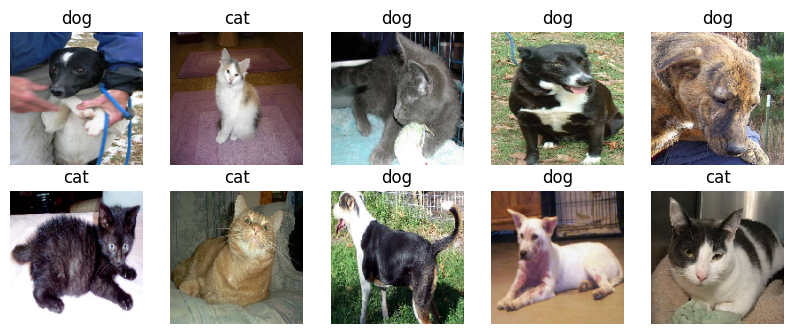

In [57]:
# Display the first five images in the test dataset and their prediction results

import matplotlib.pyplot as plt

# Get the first five images from the test generator
test_images = next(test_generator)

first_ten = predictions[:10]

# Display the images
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[i])
    label_probability = first_ten[i]
    label ="dog" if label_probability > 0.5 else "cat"
    plt.title(label)
    plt.axis('off')
plt.show()
